In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler 

from functions.Pre_processing_Casos_Graves import *
from functions.Pre_processing_models import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection._split import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

## Criação das funções para viabilizar a aplicação do modelo:

#### Função para instanciar o modelo:

In [2]:
from sklearn.ensemble import GradientBoostingClassifier


def instantiate_GradientBoosting_model (X_train, y_train):

    param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.01],
                  'subsample'    : [0.1, 0.2, 0.4, 0.6],
                  'n_estimators' : [200, 500, 800],
                  'max_depth'    : [4, 6, 8]
                 }
    
    """param_grid = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }"""

    # Init classifier
    gb_cl = GradientBoostingClassifier()
    #gb_cl = GradientBoostingClassifier(max_depth=2, n_estimators=200, learning_rate=0.1)

    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 1)

    # Init Grid Search
    grid_cv = GridSearchCV(gb_cl, param_grid, n_jobs = -1, cv=5, scoring = "roc_auc")

    # Fit 
    grid_cv.fit(X_train, y_train)

    mean_test_score = grid_cv.cv_results_['mean_test_score'].mean()
    std_test_score = grid_cv.cv_results_['std_test_score'].mean()
    best_score = grid_cv.best_score_
    best_params = grid_cv.best_params_

    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score']}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score']}")
    #print('')

    print('#'*40)
    #print(f"mean_test_score: {grid_cv.cv_results_['mean_test_score'].mean()}")
    #print(f"std_test_score: {grid_cv.cv_results_['std_test_score'].mean()}")
    print('')
    print(f'best_score: {grid_cv.best_score_}')
    print(f'best_params_: {grid_cv.best_params_}')
    print('#'*40)
    print('')

    return mean_test_score, std_test_score, best_score, best_params

#### Criação de uma função para predição do classificador final:

In [3]:
from sklearn.ensemble import GradientBoostingClassifier

def create_final_cl(X_over, y_over, X_test, y_test, max_depth, n_estimators, learning_rate, subsample):

    # parametrizando o modelo final
    final_cl = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, subsample=subsample)
    #treinando o modelo final
    final_cl.fit(X_over, y_over)
    preds = final_cl.predict(X_test)
    accuracy_score(y_test, preds)

    print('accuracy_score:', accuracy_score(y_test, preds))
    print('#'*40)

    print('"""Métricas f1_score:"""')
    print('f1: ', f1_score(y_test, preds))
    print('Macro: ', f1_score(y_test, preds, average='macro'))
    print('Micro: ', f1_score(y_test, preds, average='micro'))
    print('weighted: ', f1_score(y_test, preds, average='weighted'))
    print('#'*40)
    print('"""Métricas precision_score:"""')
    print('Precision: ', precision_score(y_test, preds))
    print('Macro: ', precision_score(y_test, preds, average='macro'))
    print('Micro: ', precision_score(y_test, preds, average='micro'))
    print('weighted: ', precision_score(y_test, preds, average='weighted'))

    return preds, final_cl

#### Criação de funções para plotagem de métricas:

In [4]:
def plot_conf_matrix (X_test, y_test, preds, final_cl):

    confusion_matrix(y_test, preds)
    matrix = plot_confusion_matrix(final_cl, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    print(classification_report(y_test, preds))


def plot_roc_curve(y_test, preds):
    
    print('roc_auc_score: ', roc_auc_score(y_test, preds, multi_class='ovr'))

    fpr, tpr, _ = metrics.roc_curve(y_test,  preds)
    auc = metrics.roc_auc_score(y_test, preds)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

def plot_feature_importance(final_cl, list_features):
    # plot feature importance
    imp_features = final_cl.feature_importances_
    df_imp_features = pd.DataFrame({"features":list_features}).join(pd.DataFrame({"weights":imp_features}))
    df_imp_features = df_imp_features.sort_values(by=['weights'], ascending=False)
    df_imp_features.plot(x="features", y="weights", kind="bar", figsize=(8, 4))
    plt.show()

#### Criação de uma função para aplicar o modelo para o período de tempo escolhido:

In [5]:
def apply_periodos (d, df):
    for i in range (0,838,30):
    
        #treino!
        data_inicio = df['data_notificacao'][0] + pd.Timedelta(days = i)
        data_fim_treino = data_inicio + pd.Timedelta(days = int(d/2))
        data_fim = data_inicio + pd.Timedelta(days = d)
        
        treino = df[(df['data_notificacao'] >= data_inicio) & (df['data_notificacao'] <= data_fim_treino )]
        X_train = treino.drop(labels=['death', 'data_notificacao'], axis=1)
        y_train = treino['death']

        #teste!
        teste = df[(df['data_notificacao'] >= data_fim_treino) & (df['data_notificacao'] <= data_fim )]
        X_test = teste.drop(labels=['death', 'data_notificacao'], axis=1)
        y_test = teste['death']

        oversample = RandomOverSampler(sampling_strategy='minority')
        X_over, y_over = oversample.fit_resample(X_train, y_train)

        print('Início do período: ', data_inicio)
        print('Final do período: ', data_fim)

        ####################################################
        #              APLICANDO O MODELO                  #
        ####################################################

        list_random_states = [0, 12, 42, 50, 54, 68, 79, 81, 92, 112]
        #list_random_states = [0,12,42,50,54,68,79,81,92,112]

        mean_test_scores = []
        std_test_scores = []
        best_scores = []
        best_params = []

        for random_state in list_random_states:

            mean_test_score, std_test_score, best_score, best_param = instantiate_GradientBoosting_model(X_over, y_over)

            mean_test_scores.append(mean_test_score)
            std_test_scores.append(std_test_score)
            best_scores.append(best_score)
            best_params.append(best_param)

        idx = best_scores.index(max(best_scores))
        best_param = best_params[idx]
        
        preds, final_cl = create_final_cl(X_over, y_over, X_test, y_test, best_param['max_depth'], best_param['n_estimators'], best_param['learning_rate'], best_param['subsample'])
        
        plot_conf_matrix (X_test, y_test, preds, final_cl)

        plot_roc_curve(y_test, preds)

        plot_feature_importance(final_cl, list_features)


## Lendo o dataset:

In [6]:
df = pd.read_csv('..\Data\Casos Graves\df_casos_graves')

### Utilizando a class de pré-processamento para preparar o dataset:

In [7]:
list_features = ["SYMPTOM_COUGH",'SYMPTOM_COLD','SYMPTOM_AIR_INSUFFICIENCY','SYMPTOM_FEVER','SYMPTOM_LOW_OXYGEN_SATURATION','SYMPTOM_BREATHING_CONDITION','SYMPTOM_TORACIC_APERTURE','SYMPTOM_THROAT_CONDITION',
                'SYMPTOM_HEADACHE','SYMPTOM_BODY_PAIN','SYMPTOM_DIARRHEA','SYMPTOM_RUNNY_NOSE','SYMPTOM_NOSE_CONGESTION','SYMPTOM_WEAKNESS','SYMPTOM_ANOSMIA_OR_HYPOSMIA','SYMPTOM_NAUSEA','SYMPTOM_LACK_OF_APPETITE',
                'SYMPTOM_ABDOMINAL_PAIN','SYMPTOM_CONSCIOUSNESS_DEGRADATION','DISEASE_HEART_OR_VASCULAR','DISEASE_DIABETES','DISEASE_HYPERTENSION','DISEASE_RESPIRATORY','DISEASE_OBESITY','DISEASE_KIDNEY','DISEASE_IMMUNOSUPPRESSION',
                'DISEASE_TABAGIST','DISEASE_ETILISM','DISEASE_LIVER','DISEASE_NEUROLOGIC','death', 'idade', 'sexo_Feminino','sexo_Masculino', 'data_notificacao']

In [8]:
Pre_processing_models_df = Pre_processing_models(df)
Pre_processing_models_df.run_graves()

df = Pre_processing_models_df.df
df = df[list_features]
df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])
df = df.sort_values(by='data_notificacao', ascending=True)
df = df.reset_index()
df = df.drop("index", axis=1)
df

C:\Users\maril\AppData\Local\Temp\ipykernel_41396\3432879523.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_notificacao'] = pd.to_datetime(df['data_notificacao'])


,SYMPTOM_COUGH,SYMPTOM_COLD,SYMPTOM_AIR_INSUFFICIENCY,SYMPTOM_FEVER,SYMPTOM_LOW_OXYGEN_SATURATION,SYMPTOM_BREATHING_CONDITION,SYMPTOM_TORACIC_APERTURE,SYMPTOM_THROAT_CONDITION,SYMPTOM_HEADACHE,SYMPTOM_BODY_PAIN,...,DISEASE_IMMUNOSUPPRESSION,DISEASE_TABAGIST,DISEASE_ETILISM,DISEASE_LIVER,DISEASE_NEUROLOGIC,death,idade,sexo_Feminino,sexo_Masculino,data_notificacao
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.356522,0,1,2020-02-26
1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-26
2,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0.217391,1,0,2020-02-27
3,1,0,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0.278261,0,1,2020-02-27
4,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0.260870,1,0,2020-02-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36430,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,1,0,2022-06-12
36431,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.556522,0,1,2022-06-12
36432,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.573913,1,0,2022-06-12
36433,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0,1,2022-06-13


### Aplicação do modelo considerando períodos de 90 dias, deslocando cada período em 30 dias:

Início do período:  2020-02-26 00:00:00
Final do período:  2020-05-26 00:00:00
########################################

best_score: 0.9708045640366858
best_params_: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 800, 'subsample': 0.6}
########################################

########################################

best_score: 0.9706083955106818
best_params_: {'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 800, 'subsample': 0.6}
########################################

accuracy_score: 0.7739771965124078
########################################
"""Métricas f1_score:"""
f1:  0.5073099415204677
Macro:  0.680330340647092
Micro:  0.7739771965124077
weighted:  0.7742479639601804
########################################
"""Métricas precision_score:"""
Precision:  0.5055852355512385
Macro:  0.6799016638043691
Micro:  0.7739771965124078
weighted:  0.7745227878371438


c:\Users\maril\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


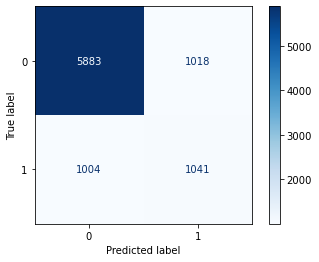

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      6901
           1       0.51      0.51      0.51      2045

    accuracy                           0.77      8946
   macro avg       0.68      0.68      0.68      8946
weighted avg       0.77      0.77      0.77      8946

roc_auc_score:  0.6807658009239298


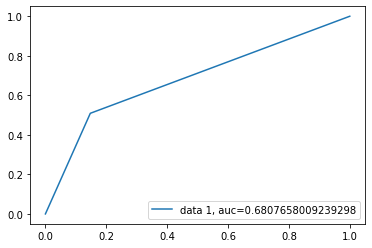

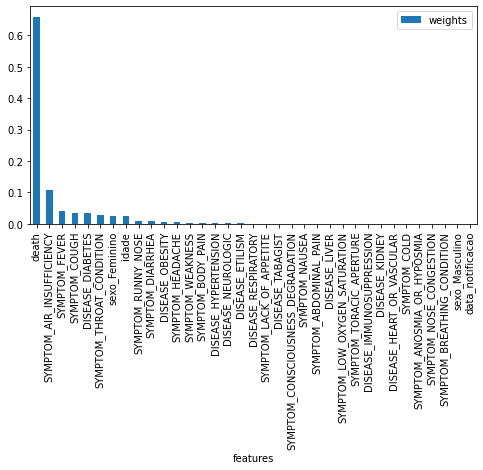

Início do período:  2020-03-27 00:00:00
Final do período:  2020-06-25 00:00:00


KeyboardInterrupt: 

In [9]:
apply_periodos(90, df)